# Noise2Self for Super-Resolution Microscopy

This is a simple notebook demonstrating the principle of using self-supervision to train denoising networks, applied to PALM super-resolution microscopy data.

The characteristic feature of PALM is sparse Poisson sampling from a continuous structure.

The independence structure we exploit is the independence between individual fluorescence events.

Here, we show this on real experimental data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [16]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor, nn

# Model

In [5]:
device = 'cpu'

In [6]:
from util import getbestgpu
#device = getbestgpu()

For our model, we use a short UNet with two levels of up- and down- sampling

In [7]:
from models.babyunet import BabyUnet

model = BabyUnet(width = 32)

# Training

In [8]:
from torch.nn import MSELoss, PoissonNLLLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss()
mse = MSELoss()

loss_function = PoissonNLLLoss()

In [9]:
optimizer = Adam(model.parameters(), lr=0.001)

# Data

In [12]:
from loader.smlm_datasets import get_localization_source

data_dir = './data/microtubules-data-annapalm'

file_type = 'smlm'
train_dir = os.path.join(data_dir, 'train')
source_train = get_localization_source(train_dir, file_type=file_type, target_size=(512, 512), A_frame=1000, B_frame=1000, A_frame_limit=[0, 6000], B_frame_limit=[0, 6000], memory_cache=True, repeat=30)
source_valid = get_localization_source(train_dir, file_type=file_type, target_size=(512, 512), A_frame=1000, B_frame=1.0, A_frame_limit=[0, 6000], B_frame_limit=[0, 1.0], memory_cache=True, repeat=1)

Found 7 samples in ./data/microtubules-data-annapalm/train.
Found 7 samples in ./data/microtubules-data-annapalm/train.


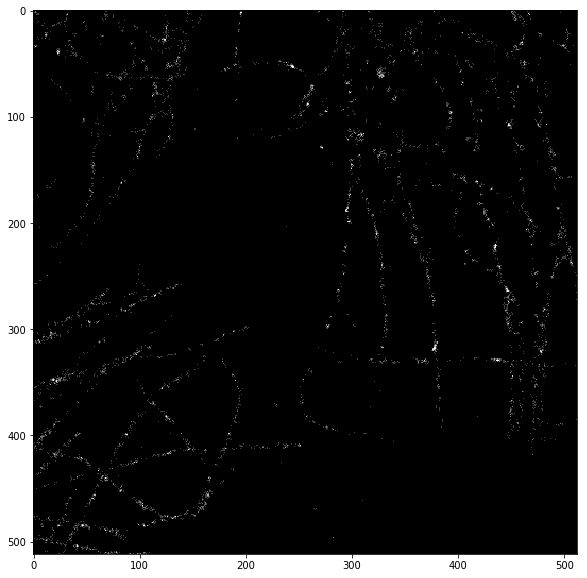

In [13]:
a, b, c = source_valid[0]
plt.figure(figsize=(10,10))
plt.imshow(a[:,:,0], cmap = 'Greys_r')

In [17]:
steps =  1000 #my.config.steps
# api.log('Starting Noise2Self training for '+str(steps) + 'steps.')
# self.dash = await api.createWindow(type="Im2Im-Dashboard", name="Noise2Self Training", w=25, h=10, data={'display_mode': 'all', 'metrics': ["loss", "val_loss"], 'callbacks': ['onStep']})

for i, batch in enumerate(source_train):

    input_arr, target_arr, path = batch
    input_tensor = torch.Tensor(input_arr[:, :, 0]).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.Tensor(target_arr[:, :, 0]).unsqueeze(0).unsqueeze(0)
    #if api.TAG == 'GPU' and gpu_available:
    if device != 'cpu':
        input_tensor, target_tensor = input_tensor.cuda(), target_tensor.cuda()

    model.train()
    output_tensor = model(input_tensor)
    loss = loss_function(output_tensor, input_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 5 == 0:
        input_arr, target_arr, path = source_valid[0]
        input_tensor = torch.Tensor(input_arr[:, :, 0]).unsqueeze(0).unsqueeze(0)
        target_tensor = torch.Tensor(target_arr[:, :, 0]).unsqueeze(0).unsqueeze(0)
        # if api.TAG == 'GPU' and gpu_available:
        if device != 'cpu':
            input_tensor, target_tensor = input_tensor.cuda(), target_tensor.cuda()
        model.eval()
        net_output = model(input_tensor).exp()
        val_loss = mse(net_output, target_tensor).item()
        info = "Loss (" + str(i)+ "): " + str(np.round(loss.item(), 3))+ ","+ str(np.round(val_loss, 5))
        print(info)
        # api.log(info)
        # api.showStatus(info)
        # await self.dash.updateCallback('onStep', i, {'loss': float(str(loss.item())), 'val_loss': float(str(val_loss))})
        # label = 'Step ' + str(i)
        # await self.plot_tensors([input_tensor[0], net_output[0], target_tensor[0]], label,
        #            ["Input", "Output", "Ground Truth"])
    if i >= steps:
        break

/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loss (0): 1.589,5.23841
Loss (5): 0.744,5.90427


KeyboardInterrupt: 